In [1]:
%%capture --no-display
!pip install moviepy
!pip install --upgrade tvb-library
!pip install --upgrade tvb-data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tvb_model_reference.src.nuu_tools_simulation_human as tools

from tvb_model_reference.simulation_file.parameter.parameter_M_Berlin import Parameter
from tvb_model_reference.view.plot_human import multiview_one, prepare_surface_regions_human
from analyses import *

parameters = Parameter()

/home/master/anaconda3/envs/tvbadexgraph/lib/python3.10/site-packages/tvb/datatypes/surfaces.py:63: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


# Load results

192.8525940603304
192.74884140565294


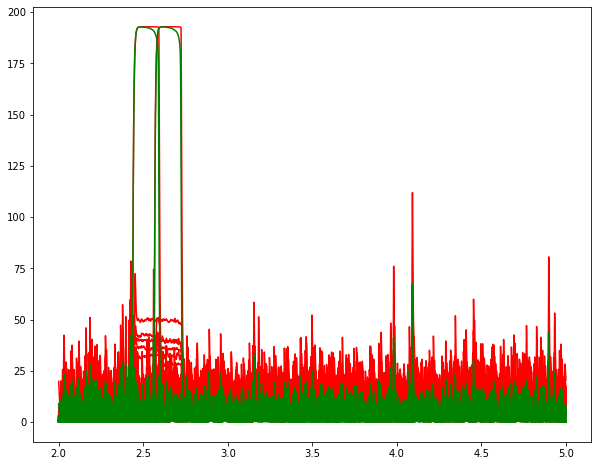

In [3]:
# Select a folder_root

folder_root = '/media/master/Nuevo vol/Internship/Data/hpc_tvbadex/results/' # Hard disk in ubuntu

# Define the parameters that we will use
cut_transient = 2000.0
run_sim = 5000.0
S = 0.5
b_e = 120.0
E_L_e = -60.0
E_L_i = -80.0
T = 5.0
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

label_sim = '_a_' + str(S) + '_b_' + str(b_e) + '_ELI_' + str(E_L_i) + \
            '_ELE_' + str(E_L_e) + '_T_' + str(T) + '/'

file_name = folder_root + label_sim

# Draw plots of the firing rates
result = tools.get_result(file_name,cut_transient,run_sim)
time_s = result[0][0]*1e-3 #from ms to sec
FR_exc = result[0][1][:,0,:]*1e3 # from KHz to Hz; Excitatory firing rate
FR_inh = result[0][1][:,1,:]*1e3 # from KHz to Hz; Inhibitory firing rate
time_s = np.array(time_s, dtype=float)
del result

ax.plot(time_s, FR_inh, label=r'$v_i$', c='r')
ax.plot(time_s, FR_exc, label=r'$v_e$', c='g')
#ax.set(title=f'S: {S}', xlabel='Time(s)', ylabel='FR(Hz)',
#      xlim=(2, 5), ylim=(0, 5 + max([np.amax(FR_exc), np.amax(FR_inh)])))
print(np.max(FR_inh))
print(np.max(FR_exc))
plt.show()

# Functions for determining if a time series is UD state or AI state (although there are some in-betweens)

In [4]:
import scipy.signal as signal
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def exponential(x, A, k):
    return A*np.exp(-k*x)

def sing_bi_modal_fit(time_trace, do_plot=False):
    """This function returns either 0 if AI or 1 if U-D state. Will return 0 as well if broken point.
    That way we will count the number of U-D states in one simulation by summing all the values.
    
    When histogram is bimodal: U-D, value 0
    When histogram is single mode: AI, value 1
    
    The process this algorithm does is:
        Tries to fit the histogram of the input time-trace to a Gaussian curve
        Then tries to fit the histogram of time-trace to a sum of two Guassians
        If any of the two fits cannot be done, the state will be assigned to the only possible fit
        If both fits can be done, then the fit with better R2 score on the data is selected as state.
        
    However, if no fit is possible, then it will return a np.nan value. 
        
    Parameters
    -------
    time_trace: ndarray
        Array containing the FR time trace of a single region.
    
    do_plot: bool
        Select if one wants to obtain a plot or not.
        
    Returns
    -------
    val: 0, 1 or np.nan
        Depending on if the time-trace provided is U-D, AI state or no possible fit was possible to apply.
    """
    if np.max(time_trace) > 120:
        return 0
    else:
        range_bins = (0, 100) 
        n_bins = 101

        hist, bins = np.histogram(time_trace, bins=n_bins, range=range_bins)
        mean_hist = np.mean(hist)
        width = 0.7 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2
        
        sing_failed = False
        expected_sing = (10, 1, 5000)
        try:
            params_sing, _ = curve_fit(gauss, center, hist, expected_sing)
        except:
            sing_failed = True
        else:
            params_sing, _ = curve_fit(gauss, center, hist, expected_sing)
            SS_res = np.sum((hist - gauss(center, *params_sing))**2)
            SS_tot = np.sum((hist - mean_hist))
            R_2_sing = 1 - SS_res / SS_tot

        bi_failed = False
        expected_bi = (4, 1, 5000, 15, 1, 2000)
        try:
            params_bi, _ = curve_fit(bimodal, center, hist, expected_bi)
        except:
            bi_failed = True
        else:
            params_bi, _ = curve_fit(bimodal, center, hist, expected_bi)
            SS_res = np.sum((hist - bimodal(center, *params_bi))**2)
            SS_tot = np.sum((hist - mean_hist))
            R_2_bi = 1 - SS_res / SS_tot
        x_fit = np.linspace(center[0], center[1], center.size)

        if do_plot:
            plt.bar(center, hist, align='center', width=width)
            if not sing_failed:
                plt.plot(center, gauss(center, *params_sing), color='red', lw=3)
            if not bi_failed:
                plt.plot(center, bimodal(center, *params_bi), color='green', lw=3)
            plt.show()
            plt.close()
            
        # Now it's time to handle the results of the fits
        if bi_failed and sing_failed:
            # If both of them failed, we try one last resort. Some U-D histogram's look like exponential
            all_failed = False
            try:
                params_exp, _ = curve_fit(exponential, center, hist, (10000, 100))
            except:
                # If the fit to the exponential does not work. We return a nan as total failure of fit
                all_failed = True
                return np.nan
            else:
                return 1  # We have U-D case
        
        elif bi_failed and not sing_failed:
            return 1  # Single mode didn't fail, return AI state
        
        elif sing_failed and not bi_failed:
            return 0  # Bimodal didn't fail, return U-D state
        
        else:
            # If neither of them failed, see which R_2 score is better
            if R_2_bi > R_2_sing:
                return 0
            else:
                return 1
            
            
def sing_bi_modal_peaks(time_trace, do_plot=False):
    """This function returns either 0 if AI or 1 if U-D state. Will return 0 as well if broken point.
    That way we will count the number of U-D states in one simulation by summing all the values.
    
    When histogram is bimodal: U-D, value 0
    When histogram is single mode: AI, value 1
    
    The process this algorithm does is:
        Find the peaks in the histogram
        Take the two peaks with maximum prominence
        If one of the peaks appears @ less than 5Hz, then UD state
        Else AI
        
    Parameters
    -------
    time_trace: ndarray
        Array containing the FR time trace of a single region.
    
    do_plot: bool
        Select if one wants to obtain a plot or not.
        
    Returns
    -------
    val: 0, 1
        Depending on if the time-trace provided is U-D or AI state.
    """
    if np.max(time_trace) > 120:
        return 1
    else:
        range_bins = (0, 100) 
        n_bins = 101

        hist, bins = np.histogram(time_trace, bins=n_bins, range=range_bins)
        mean_hist = np.mean(hist)
        width = 0.7 * (bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2
        idx_peaks, props = signal.find_peaks(np.concatenate(([min(hist)],hist,[min(hist)])), prominence=100)
        idx_peaks -= 1
        if idx_peaks.size > 1:
            idx_peaks = idx_peaks[np.argpartition(props['prominences'], -2)[-2:]]
            
        if do_plot:
            plt.bar(center, hist, align='center', width=width)
            plt.plot(idx_peaks, hist[idx_peaks], 'r*')
            plt.show()
            plt.close()
        
        if np.min(idx_peaks) <= 5:  # Discuss this value
            return 0
        else:
            return 1
            
def count_ratio_AI(FR, type_alg='peaks', do_plot=False):
    running_count = 0 
    for fr_idx in range(68):
        time_trace = FR[:, fr_idx]
        if type_alg == 'peaks':
            running_count += sing_bi_modal_peaks(time_trace, do_plot=do_plot)
        elif type_alg == 'fits':
            running_count += sing_bi_modal_fit(time_trace, do_plot=do_plot)
        else:
            raise ValueError('Select an adequate type_alg. Either peaks or fits')
    return running_count / 68

# We have to be aware of the limits of these functions.

### About the fits algorithm
The fits function applies the following algorithm to a time series (either exc or inh FR of one node) to determine if its UD or AI state.
- Obtains the histogram of the FR values.
- Tries to fit the histogram to a Gaussian curve
- Then tries to fit the histogram to a sum of two Guassians
- If none of the fits can be done, it tries to fit the histogram to a decaying exponential, since some of the UD states have histograms with that shape. If it can fit, then UD, if not, returns nan.
- If one of the two fits cannot be done, the state will be assigned to the only possible fit
- If both fits can be done, then the fit with better R2 score on the data is selected as state.

Therefore, some things that we might be missing are:
- Problems in the fitting of the algorithm. Since we will be performing numerous fits we won't be checking the performance of those fits. Therefore, the rate of error might be important. If this study is deemed interesting, it would be nice to do a test on ground truth data in different situations (mainly original set of parameters for AI and UD).
- Oscillatory patterns will probably have multiple peaks and will be better fitted by a gaussian mixture. Therefore, possible oscillations that do not correspond to UD states might be assigned as UD states. One possibility could be to have an extra cathegory describing oscillatory states (like UD) but where the valleys/minimum values of the oscillatory states are over a certain threshold. As an example, it's weird to label oscillatory dynamics with the minima being @ 10Hz.
- UD states 

### About the peaks algorithm


In [5]:
count_ratio_AI(FR_inh, type_alg='peaks', do_plot=False)

0.058823529411764705

In [6]:
# Take one time trace and try to analyze the up and down states.
# My current idea is that we will have to define an absolute threshold of up state
both_failed = 0

# for fr_idx in range(68):
#     FR = FR_inh
#     time_trace = FR[:, fr_idx]

#     idx, train_shift, train_bool = detect_UP(time_trace, ratioThreshold=0.3, len_state=20, gauss_width_ratio = 10,
#                                             sampling_rate=1/parameters.parameter_integrator['dt'])
#     plt.plot(time_s, time_trace)
#     ylim = (-3, np.amax(time_trace) + 2)

#     time_s = np.array(time_s, dtype=float)

#     plt.fill_between(time_s, min(ylim), max(ylim), where=train_bool == 1,
#                     color='k', alpha=0.3) #transform=ax.get_xaxis_transform())

#     plt.plot(time_s, train_shift)
#     plt.ylim(ylim)
#     plt.show()
#     up_mean_len, down_mean_len = mean_UD_duration(FR, dt=parameters.parameter_integrator['dt'],
#                                                       ratio_threshold=0.2, len_state=20, gauss_width_ratio=10)
#     print(up_mean_len, down_mean_len)
    
#     print(sing_bi_modal_peaks(time_trace, do_plot=True))


### Comments on how to analyze the results.


First of all we can see that when having one type of AI dynamics, it will usually correctly detect the up states.
<div>
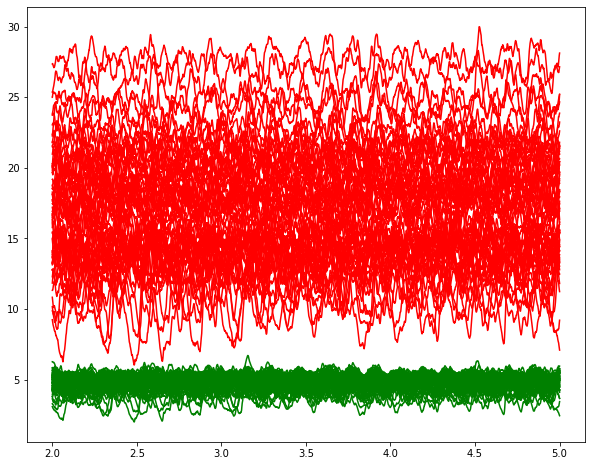
</div>
<div>
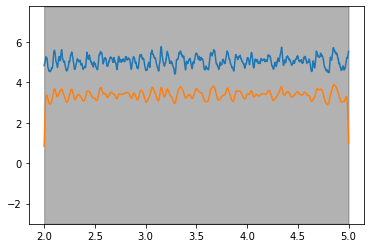
</div>
<div>
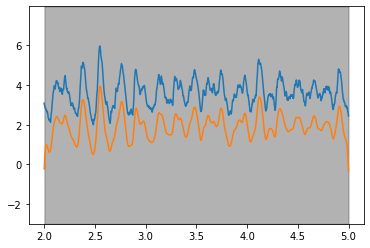
</div>


However, we have some combinations that result in weird cases that are clearly silent and we will obtain different values that we don't want. So we want to put like a threshold on variation. I mean that if the value does not go up a certain value, for instance let's say ~0.5Hz, that will be a silent state. Might be interesting to ask about it. For instance observe this case:
S = 0.5
b_e = 0.0
E_L_e = -80.0
E_L_i = -60.0
T = 40.0
<div>
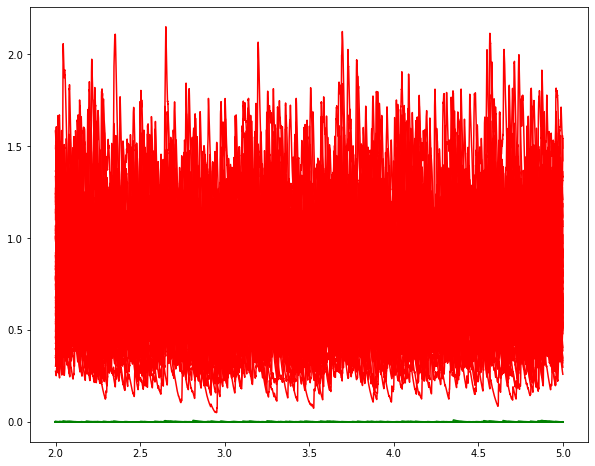
</div>
Excitatory firing rate analyses of up and down state duration:
<div>
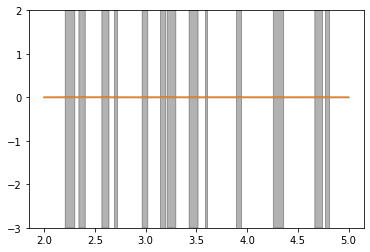
</div>
Inhibitory firing rate analyses of up and down state duration:
<div>
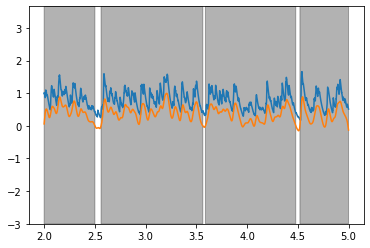
</div>

I am guessing we can let this slide. It will be hard to recollect information about true up and down states. This will be things that will have to be analyzed together both for excitatory and inhibitory. Maybe it is possible to combine the different measures to have a prediction of up and down states. One could even derive a classification algorithm with this feature extraction lol. However I am sure there are better algorithms.

For smaller values of T, we have different behaviors:
<div>
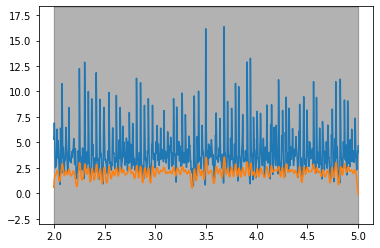
</div><div>
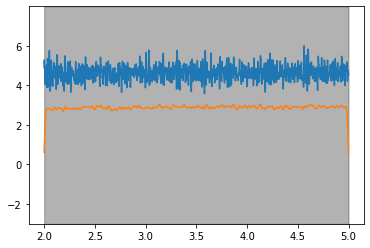
</div><div>
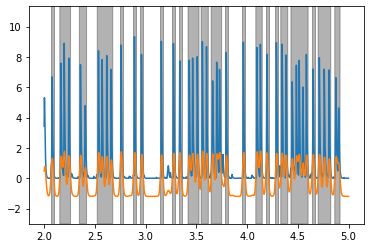
</div>

For T = 5ms it is usually hard to see UD states although similar dynamics might appear. I am guessing that it will depend on the parameters. However, these possible, probably few, down states in these cases will be lost in the averaging. It would really cool to be able to cathegorize the dynamics in one node as UD and sum the number of UD nodes in the simulation. I think it might be an interesting parameter.

**Why interesting?**
- It will be a measure of the heterogeneity in the dynamics as a function of the parameter sweeps.
- Might represent different situations of brain dynamics: For instance REM sleep or light sleep where some regions might be up and down and others in AI?
- Maybe we can try to include the oscillations as well.
- It will be good to have an automatic detection of up and down time traces I think

**The smaller the T, the less UD states that we will observe. So we can hypothesize that the smaller the T gets, the shorter the down duration that we will obtain.**

# Seeing how the FC changes from before to after stimuli